<a href="https://colab.research.google.com/github/poudel4samikshya/Sales_Forecasting_Data_Science/blob/main/Future_Sales_Datascience_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  importing  packages

import numpy as np                   # Multi-dimensional array object
import pandas as pd                  # Data Manipulation
import seaborn as sns                # Data Visualization
import matplotlib.pyplot as plt      # Data Visualization
import plotly.express as px          # Interactive Data Visualization
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor # for modeling


# Data Manipulation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To Predict Total sales for every product and store in the next month We are provided with daily historical sales data.

**The task is to forecast the total amount of products sold in every shop for the test set.** 

In [ ]:
# reading data from files
train_ds = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/sales_train.csv")
test_ds = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/test.csv")
items_ds = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/items.csv")
item_categories_ds = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/item_categories.csv")
shops_ds = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/shops.csv")
submission = pd.read_csv("/content/drive/MyDrive/Future_sales_data/competitive-data-science-predict-future-sales/sample_submission.csv")


In [ ]:
submission.tail()

,ID,item_cnt_month
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


# Exploratory data Analysis

**Data fields given in files (Discription)**

1) ID - an Id that represents a (Shop, Item) tuple within the test set

2) shop_id - unique identifier of a shop

3) item_id - unique identifier of a product

4) item_category_id - unique identifier of item category

5) item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

6) item_price - current price of an item

7) date - date in format dd/mm/yyyy

6) date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

7) item_name - name of item

8) shop_name - name of shop

9) item_category_name - name of item category

In [ ]:
# checking the first 5 data to check it's attributes and lean about the data_fields
train_ds.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
#checking if there is any null value
train_ds.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
#Displaying Metadata/Information about Training Data
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
#Displaying Stats on Training Data
train_ds.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


Here, it could be noticed that item_price and item_cnt_day consist of Negative Numbers. These values should be changed into positive because as the value is in negative it does not make any sense, item price being in negative

# Data Preparation for sales_train.csv




In [ ]:
#Changing Negative numbers into Positive
train_ds['item_price']=train_ds['item_price'].abs()
train_ds['item_cnt_day']=train_ds['item_cnt_day'].abs()

**As the item count per month is to be predicted, item_cnt_day will be converted to item_cnt_month**

In [ ]:
#Grouping item price and item count per month
train_ds = train_ds.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'last','item_cnt_day':'sum'}).reset_index()
#Changing the name of the item_cnt_day to item_cnt_month
train_ds = train_ds.rename(columns={'item_cnt_day':'item_cnt_month'})
print(train_ds)

         date_block_num  shop_id  item_id  item_price  item_cnt_month
0                     0        0       32       221.0             6.0
1                     0        0       33       347.0             3.0
2                     0        0       35       247.0             1.0
3                     0        0       43       221.0             1.0
4                     0        0       51       127.0             2.0
...                 ...      ...      ...         ...             ...
1609119              33       59    22087       119.0             6.0
1609120              33       59    22088       119.0             2.0
1609121              33       59    22091       179.0             1.0
1609122              33       59    22100       629.0             1.0
1609123              33       59    22102      1250.0             1.0

[1609124 rows x 5 columns]


Since we are predicting the sales count of every shop, we want to visualize how shops are doing in **train data** set in terms of selling products

---



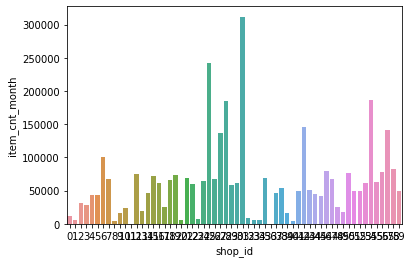

In [ ]:
#Grouping shop_id and item count per month
train_ds_shop = train_ds.groupby(['shop_id']).agg({'item_cnt_month':'sum'}).round().reset_index()

# vizualizing how the shops are doing in the market
sns.barplot(x='shop_id',y= 'item_cnt_month', data = train_ds_shop)

**Correlation** is a good way to find whether the data columns have linear relationship with item_cnt_day or not. If the correlation value is closer to one, then the data columns are positively related.

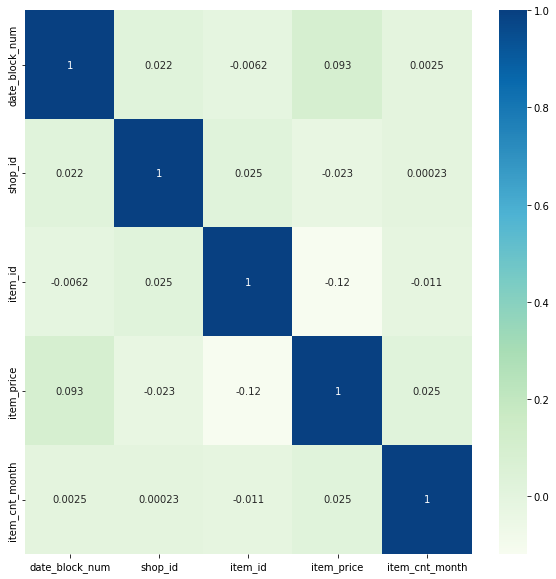

In [ ]:
#Calculating Correlation
correlation=train_ds.corr()

#Plotting correlation using heat map
plt.figure(figsize=(10,10))
corr_heatmap=sns.heatmap(correlation,annot=True,cmap="GnBu")

Looking at the heatmap, we can say that item_price, shop_id and month number(date_block_num) are positivly co related whereas item_id has negative coreation


In [ ]:
#checking item.csv to see how the file is
items_ds.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
print(items_ds.item_category_id.unique())
print(" ")
print("Number of Unique ID : ", len(items_ds.item_category_id.unique()))

[40 76 55 19 30 23 37 41 57 43 78 54 49 44 45 77 73 31 75 58 56 38 67 59
 60 74 21 28 20 24 29 70 22 32 62 25 72  4 63 27 18 26 64 15 68  0  2  5
  1  3  6 35 65 14 13 10 11 12 48 71 69  7 33 34 16 66 39 52 46 42 61  8
 80  9 17 36 47 82 81 50 51 79 53 83]
 
Number of Unique ID :  84


In [ ]:
test_ds.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
#checking if there is any null in test data
test_ds.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [ ]:
train_ds['item_price'].isnull().values.any()

False

Looking at the test data, Test data only consists of two data columns shop_id and item_id,that means it has some column missing such as date_block_num, item_price, and item_cnt_month, we need to add other data columns like date_block_num and item priceto make test.csv same as sales_train.csv



# Data Preperation for test.csv file

For date_block_num : we made date_block_num as 34 because: date_block_num reprsents the number of month so, october 2015 - is the 33rd month in dataset)
 if we are predicting for the november 2015, the date_block_number for that month would be 34

 

In [ ]:
#Adding date_block_num to the Test data
test_ds['date_block_num']=34
test_ds = test_ds[['date_block_num','shop_id','item_id']]
print(test_ds)

        date_block_num  shop_id  item_id
0                   34        5     5037
1                   34        5     5320
2                   34        5     5233
3                   34        5     5232
4                   34        5     5268
...                ...      ...      ...
214195              34       45    18454
214196              34       45    16188
214197              34       45    15757
214198              34       45    19648
214199              34       45      969

[214200 rows x 3 columns]


In [ ]:
# printing the unique shop_id that is in test_data 
print(test_ds['shop_id'].unique())

[ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]


For the item_price: we use the .last() function to get the last item_price values of that particular item_id from the sales_train.csv add the item_price column on test.csv

In [ ]:
#Adding the latest item price from the training data into test data into their respective item id
item_price=dict(train_ds.groupby('item_id')['item_price'].last().reset_index().values)
test_ds['item_price']=test_ds.item_id.map(item_price)
print(test_ds)

        date_block_num  shop_id  item_id  item_price
0                   34        5     5037      1499.0
1                   34        5     5320         NaN
2                   34        5     5233      1199.0
3                   34        5     5232      1199.0
4                   34        5     5268         NaN
...                ...      ...      ...         ...
214195              34       45    18454        99.0
214196              34       45    16188      1359.0
214197              34       45    15757       229.0
214198              34       45    19648        79.2
214199              34       45      969       198.0

[214200 rows x 4 columns]


Note: we have some "NAN"item_price for item_id in test_ds, because those item_id werenot introduced in sales_train.csv

So, In order to resolve that issue we will take the median of the item_price and replace NAN with that value. 

**why didnot we drop the NAN value?**
-> for obvious reason, those are the new item_id that were introduced in test.csv and if we drop it, it might cause problem in prediction.


In [ ]:
#Replacing Missing Value with median price
print(test_ds['item_price'].unique())
test_ds['item_price']=test_ds['item_price'].fillna(test_ds['item_price'].median())
test_ds['item_price']

[1.49900000e+03            nan 1.19900000e+03 3.99900000e+03
 3.49000000e+02 2.99000000e+02 9.90000000e+01 9.99900000e+03
 1.29900000e+03 1.82900000e+03 9.99000000e+02 1.19800000e+03
 2.99900000e+03 2.79900000e+03 3.98000000e+02 3.79900000e+03
 3.19900000e+03 3.29000000e+03 5.69000000e+03 2.49000000e+02
 3.41000000e+03 4.29000000e+03 3.49000000e+03 7.99000000e+02
 4.99000000e+02 3.59000000e+03 1.39900000e+03 5.99000000e+02
 1.09900000e+03 1.14900000e+03 3.99000000e+02 4.89000000e+02
 5.49000000e+02 2.19900000e+03 7.99200000e+02 2.59900000e+03
 6.99000000e+02 1.79900000e+03 1.69900000e+03 1.99900000e+03
 1.59900000e+03 9.33000000e+02 9.80000000e+01 9.98000000e+02
 8.99000000e+02 3.39900000e+03 4.49900000e+03 7.59900000e+03
 3.59900000e+03 2.29900000e+03 2.39200000e+02 2.49900000e+03
 1.99000000e+02 1.23400000e+03 1.69000000e+02 2.29000000e+02
 4.49000000e+02 5.99900000e+03 4.84900000e+03 1.49000000e+02
 4.89900000e+03 3.49900000e+03 1.48000000e+02 2.48000000e+02
 1.59800000e+03 3.099000

0         1499.0
1          449.0
2         1199.0
3         1199.0
4          449.0
           ...  
214195      99.0
214196    1359.0
214197     229.0
214198      79.2
214199     198.0
Name: item_price, Length: 214200, dtype: float64

# Modeling

Before we feed our data in the model, we need to allocate our training data into X and y training sets where X represents the important features and Y represents the values that should be predicted.

In [ ]:
#allocating training data into X and y training sets
x_train=train_ds.drop('item_cnt_month',axis=1)
y_train=train_ds["item_cnt_month"]
# for test_ds 
x_test = test_ds

x_train.shape,y_train.shape

((1609124, 4), (1609124,))

# Random Forest Regression

For the no.of estimaters, it is suggested to have more than 65. We chose 100 because we thought it would be good enough number for our dataset.

In [ ]:
#Buliding Model in Random Forest Regressor
rr_model=RandomForestRegressor(n_estimators=100)
rr_model.fit(x_train,y_train)

RandomForestRegressor()

In [ ]:
#Testing the model
rr_predict = rr_model.predict(x_test)
print(rr_predict)

[1.35 1.04 1.34 ... 1.   1.23 1.  ]


In [ ]:
# storing prediction in Dataframe 
prediction_ds = {
         'predicted_item_count_month': rr_predict
        }
prediction_ds = pd.DataFrame(prediction_ds)
print (prediction_ds)

        predicted_item_count_month
0                             1.35
1                             1.04
2                             1.34
3                             1.32
4                             1.04
...                            ...
214195                        1.00
214196                        1.12
214197                        1.00
214198                        1.23
214199                        1.00

[214200 rows x 1 columns]


In [ ]:
# storing only shop_id and prediction in Dataframe 
prediction_ds_shop = {'shop_id': test_ds['shop_id'],
        'predicted_item_count': rr_predict
        }

prediction_ds_shop = pd.DataFrame(prediction_ds_shop)


print (prediction_ds_shop)


        shop_id  predicted_item_count
0             5                  1.35
1             5                  1.04
2             5                  1.34
3             5                  1.32
4             5                  1.04
...         ...                   ...
214195       45                  1.00
214196       45                  1.12
214197       45                  1.00
214198       45                  1.23
214199       45                  1.00

[214200 rows x 2 columns]


Since we are trying to see how every shops are doing in the market for the November, we are adding predicted_item_count for each shops

    shop_id  predicted_item_count
0         2                9804.0
1         3                9583.0
2         4                9632.0
3         5               10020.0
4         6               10543.0
5         7               10355.0
6        10               11526.0
7        12               10696.0
8        14                9950.0
9        15               10003.0
10       16                9880.0
11       18               10036.0
12       19               10359.0
13       21               10766.0
14       22               10552.0
15       24               10840.0
16       25               13553.0
17       26               10288.0
18       28               11257.0
19       31               14000.0
20       34                8872.0
21       35                9195.0
22       36                8871.0
23       37                8877.0
24       38                9219.0
25       39                9717.0
26       41                9468.0
27       42               12226.0
28       44   

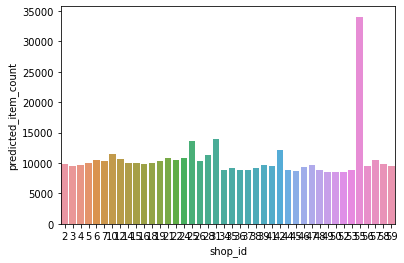

In [ ]:
#Grouping item price and item count per month
prediction_ds_shop = prediction_ds_shop.groupby(['shop_id']).agg({'predicted_item_count':'sum'}).round().reset_index()
print(prediction_ds_shop)
print(prediction_ds_shop.shape)

# visualization

sns.barplot( x = 'shop_id',y = 'predicted_item_count',data = prediction_ds_shop);

In [ ]:
# storing only item_id and prediction in Dataframe
prediction_ds_item = {'item_id': test_ds['item_id'],
        'predicted_item_count': rr_predict
        }

prediction_ds_item = pd.DataFrame(prediction_ds_item)


print (prediction_ds_item)

        item_id  predicted_item_count
0          5037                  1.35
1          5320                  1.04
2          5233                  1.34
3          5232                  1.32
4          5268                  1.04
...         ...                   ...
214195    18454                  1.00
214196    16188                  1.12
214197    15757                  1.00
214198    19648                  1.23
214199      969                  1.00

[214200 rows x 2 columns]


Since we are trying to see how every products are doing in the market for the November, we are adding predicted_item_count for each products

      item_id  predicted_item_count
0          30                  49.0
1          31                  96.0
2          32                  59.0
3          33                  52.0
4          38                  75.0
...       ...                   ...
5095    22162                  69.0
5096    22163                  59.0
5097    22164                  69.0
5098    22166                 394.0
5099    22167                  74.0

[5100 rows x 2 columns]


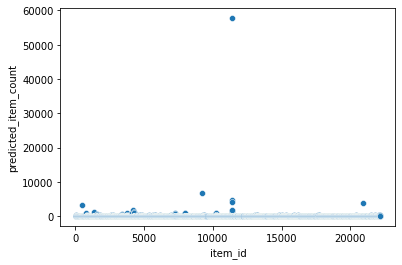

In [ ]:
#Grouping item price and item count per month
prediction_ds_item = prediction_ds_item.groupby(['item_id']).agg({'predicted_item_count':'sum'}).round().reset_index()
print(prediction_ds_item)
sns.scatterplot(x = 'item_id', y = 'predicted_item_count',data = prediction_ds_item )

# **# Professer's suggestion**


# **Since the test dataset given in kaggle doesnot have y value to compare with the predicted value (yhat) and check how good our model is so, we talked to professer about it and professer gave us a permission to use sales_train data to split  into our own train and test data.(80% and 20%) so that we can evaluate the performance of our model.**

In [ ]:
#spliting sales_train.csv file (80% train  and 20% test)
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(train_ds, test_size=0.2,random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 1287299
No. of testing examples: 321825


In [ ]:
#allocating training data into X and y training sets

#training
x_train=training_data.drop('item_cnt_month',axis=1)
y_train = training_data["item_cnt_month"]

#testing
x_test = testing_data.drop('item_cnt_month',axis=1)
y_test = testing_data["item_cnt_month"]
x_train.shape,y_train.shape

((1287299, 4), (1287299,))

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error



#Random Forest Algorithim

# Training the model

In [ ]:


#Buliding Model in Random Forest Regressor
rr_model=RandomForestRegressor(n_estimators=65)
rr_model.fit(x_train,y_train)


RandomForestRegressor(n_estimators=65)

# Testing in test data

In [ ]:
#Testing the model
rr_predict=rr_model.predict(x_test)
print(rr_predict)

[1.95384615 1.15384615 1.13846154 ... 5.63076923 8.4        1.06153846]


# Looking at the prediction we find out some prediction are only some decimal away from the actul value so, inorder to increase accuracy we truncate the decimal.

In [ ]:
#Testing the model
rr_predict=rr_model.predict(x_test)
rr_predict = np.trunc(rr_predict)
print(rr_predict)

[1. 1. 1. ... 5. 8. 1.]


In [ ]:
# storing only item_id and prediction in Dataframe
prediction = {'Actual_Y_value': y_test,
        'Predicted_Y_hat': rr_predict
        }
prediction = pd.DataFrame(prediction)


print(prediction)

         Actual_Y_value  Predicted_Y_hat
518371              1.0              1.0
83779               2.0              1.0
135246              1.0              1.0
547942              1.0              1.0
1406119             3.0              2.0
...                 ...              ...
1418571             2.0              1.0
372666              2.0              1.0
1169860             3.0              5.0
169400              2.0              8.0
612335              1.0              1.0

[321825 rows x 2 columns]


# ACCURACY CHECKING

In [ ]:

import math
# checking performance of the matrix
rmse = math.sqrt(mean_squared_error(y_test,rr_predict))
mae = mean_absolute_error(y_test,rr_predict)

  #printing
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 5.719467315903618
MAE: 0.9576322535539501


In [ ]:

y_test = y_test.to_numpy()
count = 0
a = len(y_test)
for i in range(a):
  if y_test[i] == rr_predict[i]:
    count+= 1
print(count)
print(a)
accuracy = count/a * 100
print(accuracy) 
# The accuracy is very low that means it is underfitting

197679
321825
61.424376602190634


# Graphing Actual value of Y against Predicted Y value

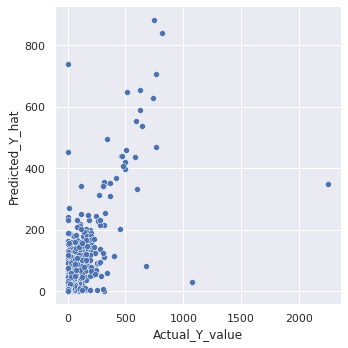

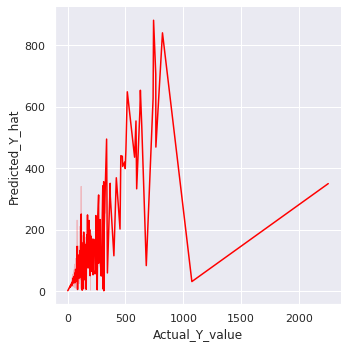

In [ ]:
sns.set(style="darkgrid")
sns.relplot(x="Actual_Y_value", y="Predicted_Y_hat", data=prediction);
sns.relplot(x="Actual_Y_value", y="Predicted_Y_hat", kind="line", data=prediction,color = "red")

# Ploting graph to see prdiction on x_test data

NameError: ignored

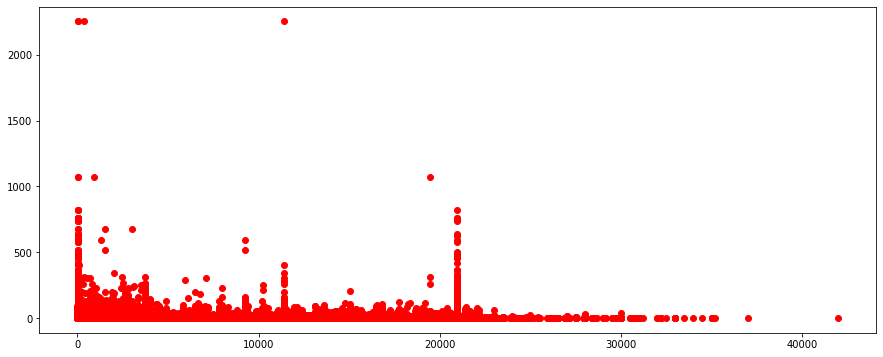

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(x_test,y_test,'ro')
ax.plot(x_test,rr_predict, 'b--')

Topics to search
1) Imputations 2) https://www.kaggle.com/pralabhpoudel/sale-prediction-regressions-and-deep-learning 3) Evaluation metrics: Accuracy score, confusion matrix, classificationn report, roc, auc and their curves 4) https://julsimon.medium.com/predicting-world-temperature-with-time-series-and-deepar-on-amazon-sagemaker-e371cf94ddb5